In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import scipy
from scipy import signal
import pickle
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

## Load raw data

In [ ]:
data = pd.read_csv('data/train.csv')

In [ ]:
data.shape

## Split data into 150,000 point segments and save

In [ ]:
num_segments = int(len(data['acoustic_data'])/150000)

In [ ]:
segment = {}

ind_save = 0
for i in range(num_segments):
    if data['time_to_failure'].values[i*150000] > data['time_to_failure'].values[(i+1)*150000-1]:
        segment['data'] = data['acoustic_data'].values[i*150000:(i+1)*150000]
        segment['time_to_failure'] = data['time_to_failure'].values[(i+1)*150000]
        with open('/Users/djustus/workspace/earthquake/data/training_data/segments/segment_%04d.pkl'%ind_save, 'wb') as f:
            pickle.dump(segment,f)
        ind_save = ind_save+1

In [ ]:
num_segments_use = ind_save

## Create Spectrograms for segments and save

In [ ]:
fs = 4000000
sampling_period = 1 / fs

spectrum = {}

for i in range(num_segments_use):
    with open('/Users/djustus/workspace/earthquake/data/training_data/segments/segment_%04d.pkl'%i, 'rb') as f:
        segment = pickle.load(f)
    _,_, s = signal.spectrogram(segment['data'], fs, window=('tukey', .25))
    spectrum['data'] = s[:33,:]
    spectrum['time_to_failure'] = segment['time_to_failure']
    with open('/Users/djustus/workspace/earthquake/data/training_data/spectrograms/spectrum_%04d.pkl'%i, 'wb') as f:
        pickle.dump(spectrum,f)

## Calculate features for segments

In [29]:
featureselection = ['mean', 'min', '10th percentile', 'median', '90th percentile', 'max', 
                    'stdev', 'skewness', 'kurtosis',
                    'num_peaks_5', 'num_peaks_10', 'num_peaks_20', 'num_peaks_50', 'num_peaks_100',
                    'mean spectral power 1500-2999', 'max spectral power 1500-2999',
                    'mean spectral power 3000-4499', 'max spectral power 3000-4499',
                    'mean spectral power 4500-5999', 'max spectral power 4500-5999',
                    'mean spectral power 6000-7499', 'max spectral power 6000-7499',
                    'mean spectral power 7500-8999', 'max spectral power 7500-8999',
                    'mean spectral power 9000-10499', 'max spectral power 9000-10499',
                    'mean spectral power 10500-11999', 'max spectral power 10500-11999',
                    'mean spectral power 12000-13499', 'max spectral power 12000-13499',
                    'mean spectral power 13500-15000', 'max spectral power 13500-15000',
                    'location of 1st of 3 highest spectral peaks', 'amplitude of 1st of 3 highest spectral peaks',
                    'location of 2nd of 3 highest spectral peaks', 'amplitude of 2nd of 3 highest spectral peaks',
                    'location of 3rd of 3 highest spectral peaks', 'amplitude of 3rd of 3 highest spectral peaks']

In [3]:
with open('/Users/djustus/workspace/earthquake/data/training_data/segments/segment_%04d.pkl'
              %1, 'rb') as f:
        segment = pickle.load(f)

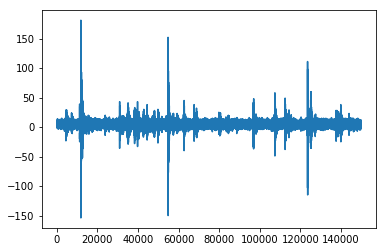

In [5]:
plt.plot(segment['data'])

In [9]:
t = np.arange(0,10,.01)

In [11]:
s = np.sin(t)
s2 = -np.sin(t)
s3 = np.cos(t)

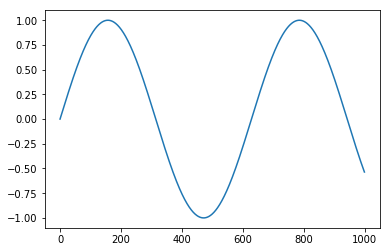

In [17]:
plt.plot(s)

In [28]:
len(signal.find_peaks(segment['data'],prominence=25)[0])

662

In [31]:
num_segments_use = 4178

In [ ]:
features = {}
featuremat = np.zeros([num_segments_use,len(featureselection)])
time_to_failure_vec = np.zeros(num_segments_use)

for segment_index in range(num_segments_use):
    featurevec = []
    with open('/Users/djustus/workspace/earthquake/data/training_data/segments/segment_%04d.pkl'
              %segment_index, 'rb') as f:
        segment = pickle.load(f)
    featurevec.append(np.mean(segment['data']))
    featurevec.append(np.min(segment['data']))
    featurevec.append(np.percentile(segment['data'],10))
    featurevec.append(np.median(segment['data']))
    featurevec.append(np.percentile(segment['data'],90))
    featurevec.append(np.max(segment['data']))
    featurevec.append(np.std(segment['data']))
    featurevec.append(scipy.stats.skew(segment['data']))
    featurevec.append(scipy.stats.kurtosis(segment['data']))
    
    peak_prominence = [5,10,20,50,100]
    for prominence in peak_prominence:
        featurevec.append(len(signal.find_peaks(segment['data'],prominence=prominence)[0]))
    
    # Spectral features
    spectral_power = abs(np.fft.fft(segment['data']))**2
    window = np.hanning(51)
    spectral_power_filt = np.convolve(window/window.sum(),spectral_power,mode='same')
    for i in range(1,10):
        featurevec.append(np.mean(spectral_power_filt[i*1500:(i+1)*1500]))
        featurevec.append(np.max(spectral_power_filt[i*1500:(i+1)*1500]))
        
    peaks = signal.find_peaks(spectral_power_filt[1:15000],distance=1000,height=1)
    top3peaks = peaks[0][np.argsort(peaks[1]['peak_heights'])[-3:]]
    top3peaks = np.sort(top3peaks)
    for i in range(3):
        featurevec.append(top3peaks[i])
        featurevec.append(spectral_power_filt[top3peaks[i]])
    
    features['featurevec'] = featurevec
    features['time_to_failure'] = segment['time_to_failure']
    with open('/Users/djustus/workspace/earthquake/data/training_data/features_v2/features_%04d.pkl'
              %segment_index, 'wb') as f:
        pickle.dump(features,f)
        
    featuremat[segment_index,:] = featurevec
    time_to_failure_vec[segment_index] = segment['time_to_failure']

In [ ]:
np.save('data/training_data/featurematrix_v2',featuremat)
np.save('data/training_data/time_to_failure_v2',time_to_failure_vec)

## Load test segments and calculate features

In [ ]:
testfiles = os.listdir('data/test/')
filenames = []
for file in testfiles:
    filename,_ = os.path.splitext(file)
    filenames.append(filename)

In [ ]:
testmat = np.zeros([len(testfiles),33])

for testfile_index in range(len(testfiles)):
    featurevec = []
    testsegment = pd.read_csv(os.path.join('data/test/',testfiles[testfile_index]))
    testsegment = testsegment['acoustic_data']
    
    featurevec.append(np.mean(testsegment))
    featurevec.append(np.min(testsegment))
    featurevec.append(np.percentile(testsegment,10))
    featurevec.append(np.median(testsegment))
    featurevec.append(np.percentile(testsegment,90))
    featurevec.append(np.max(testsegment))
    featurevec.append(np.std(testsegment))
    featurevec.append(scipy.stats.skew(testsegment))
    featurevec.append(scipy.stats.kurtosis(testsegment))
    
    # Spectral power features
    spectral_power = abs(np.fft.fft(testsegment))**2
    window = np.hanning(51)
    spectral_power_filt = np.convolve(window/window.sum(),spectral_power,mode='same')
    for i in range(1,10):
        featurevec.append(np.mean(spectral_power_filt[i*1500:(i+1)*1500]))
        featurevec.append(np.max(spectral_power_filt[i*1500:(i+1)*1500]))
        
    peaks = signal.find_peaks(spectral_power_filt[1:15000],distance=1000,height=1)
    top3peaks = peaks[0][np.argsort(peaks[1]['peak_heights'])[-3:]]
    top3peaks = np.sort(top3peaks)
    for i in range(3):
        featurevec.append(top3peaks[i])
        featurevec.append(spectral_power_filt[top3peaks[i]])
    
    
    testmat[testfile_index,:] = featurevec

In [ ]:
np.save('data/test_processed/featurematrix_test',testmat)

## Load train and test features and time_to_failure

In [ ]:
featuremat = np.load('data/training_data/featurematrix.npy')
time_to_failure_vec = np.load('data/training_data/time_to_failure.npy')
testmat = np.load('data/test_processed/featurematrix_test.npy')

## Split train/validation set

In [ ]:
trainset = np.random.choice(np.arange(len(time_to_failure_vec)),size=int(len(time_to_failure_vec)*.9),replace=False)

In [ ]:
validationset = list(set(np.arange(len(time_to_failure_vec)))-set(trainset))

In [ ]:
trainmat = featuremat[trainset,:]
validationmat = featuremat[validationset,:]

time_to_failure_train = time_to_failure_vec[trainset]
time_to_failure_validation = time_to_failure_vec[validationset]

## Normalise data

In [ ]:
scaler = StandardScaler()
scaler.fit(trainmat)

In [ ]:
trainmat_scale = scaler.transform(trainmat)
validationmat_scale = scaler.transform(validationmat)
testmat_scale = scaler.transform(testmat)

In [ ]:
def get_error(predictions,real_time):
    return(np.mean(np.abs(np.squeeze(real_time)-np.squeeze(predictions))))

## Select features to use

In [ ]:
# features_use = list(range(0,27)) + list([27,29,31])
features_use = [1]

trainmat_use = trainmat_scale[:,features_use]
validationmat_use = validationmat_scale[:,features_use]
testmat_use = testmat_scale[:,features_use]

num_features = len(features_use)

In [ ]:
for f in features_use:
    print(featureselection[f])

## Simple linear regression

In [ ]:
reg = LinearRegression().fit(trainmat_use, time_to_failure_train)

In [ ]:
predict_train = reg.predict(trainmat_use)
predict_train[predict_train<0] = 0

predict_validation = reg.predict(validationmat_use)
predict_validation[predict_validation<0] = 0

In [ ]:
print(get_error(predict_train,time_to_failure_train))
print(get_error(predict_validation,time_to_failure_validation))

In [ ]:
plt.plot(time_to_failure_train[::10],predict_train[::10],'.')
plt.plot(time_to_failure_validation,predict_validation,'.')

### Apply to test data

In [ ]:
predict_test = reg.predict(testmat_scale)
predict_test[predict_test<0] = 0

In [ ]:
df_predict = pd.DataFrame({'seg_id':filenames,'time_to_failure':predict_test})

In [ ]:
df_predict.to_csv('data/predictions_linear_reg_positive.csv',index=False)

## DNN

In [ ]:
dropout = .1

In [ ]:
inputs = tf.placeholder(tf.float32, shape=(None, num_features))
targets = tf.placeholder(tf.float32, shape=(None))
lr = tf.placeholder(tf.float32, shape=(None))
is_training = tf.placeholder(tf.bool, shape=(None))


layer1 = tf.layers.dense(inputs = inputs,
                         units = 32,
                         activation = tf.nn.relu,   
                         use_bias = True,
                         )
layer1 = tf.layers.dropout(inputs=layer1,
                           rate=dropout,
                           training=is_training)

layer2 = tf.layers.dense(inputs = layer1,
                         units = 64,
                         activation = tf.nn.relu,   
                         use_bias = True)
layer2 = tf.layers.dropout(inputs=layer2,
                           rate=dropout,
                           training=is_training)

layer3 = tf.layers.dense(inputs = layer2,
                         units = 128,
                         activation = tf.nn.relu,   
                         use_bias = True)
layer3 = tf.layers.dropout(inputs=layer3,
                           rate=dropout,
                           training=is_training)

output = tf.layers.dense(inputs = layer3,
                         units = 1,
                         activation = tf.nn.relu,   
                         use_bias = False)
predictions = tf.reshape(output, [-1])

# loss = tf.losses.mean_squared_error(labels=targets,
#                                     predictions=predictions)
loss = tf.losses.absolute_difference(labels=targets,
                                     predictions=predictions)

In [ ]:
opt = tf.train.AdamOptimizer(learning_rate=lr,
                             epsilon=.1)
train_op = opt.minimize(loss)

In [ ]:
lr_initial = .1
lr_decay = 100
num_epochs = 1000
batchsize = 128

In [ ]:
train_points = len(time_to_failure_train)
batches_per_epoch = int(train_points/batchsize)

In [ ]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
l_step = []
error_train = np.zeros(num_epochs)
error_validation = np.zeros(num_epochs)


for epoch in range(num_epochs):
    for step in range(batches_per_epoch):
        choice = np.arange(train_points)
        batch = np.random.choice(choice,batchsize,replace=False)
        choice = np.array(set(choice) - set(batch))
        _, l = sess.run([train_op,loss],feed_dict={inputs: trainmat_use[batch,:],
                                                   targets: time_to_failure_train[batch],
                                                   lr: lr_initial*.5**(int(epoch/lr_decay)),
                                                   is_training: True})
        l_step.append(l)
    

    p_train = sess.run(predictions,feed_dict={inputs: trainmat_use,
                                              is_training: False})
    p_validation = sess.run(predictions,feed_dict={inputs: validationmat_use,
                                                   is_training: False})
    
    error_train[epoch] = np.mean(np.abs(p_train-time_to_failure_train))
    error_validation[epoch] = np.mean(np.abs(p_validation-time_to_failure_validation))
    
    if epoch%100==0:
        print('epoch %i, trainerror %.3f, validationerror %.3f' 
              %(epoch, error_train[epoch], error_validation[epoch]))

In [ ]:
plt.plot(error_train)
plt.plot(error_validation)
# plt.yscale('log')

In [ ]:
predictions_train = sess.run(predictions,feed_dict={inputs: trainmat_use,is_training:False})
predictions_validation = sess.run(predictions,feed_dict={inputs: validationmat_use,is_training:False})

plt.plot(time_to_failure_train[0::10],predictions_train[0::10],'.')
plt.plot(time_to_failure_validation,predictions_validation,'.')

In [ ]:
prediction_test = np.float64(sess.run(predictions,feed_dict={inputs: testmat_scale}))

In [ ]:
df_predict_tf = pd.DataFrame({'seg_id':filenames,'time_to_failure':prediction_test})
df_predict_tf.to_csv('data/predictions_5layer_tf.csv',index=False)

## Keras model

In [ ]:
model = Sequential()
model.add(Dense(units=1, 
                input_dim=num_features, 
#                 kernel_initializer='normal', 
                activation='relu',
               ))

# model.add(Dense(units=64,
# #                 kernel_initializer='normal', 
#                 activation='relu',
#                ))

# model.add(Dense(units=128,
# #                 kernel_initializer='normal', 
#                 activation='relu',
#                ))

# model.add(Dense(1,
#                 activation='relu',
#                 use_bias=False,
# #                 kernel_initializer='normal',
#                ))
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.1,decay=.1)

In [ ]:
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [ ]:
class My_Callback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        if epoch%50==0:
            print('Epoch %d, loss %.3f' %(epoch,logs.get('loss')))
        self.losses.append(logs.get('val_loss'))
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return
    
my_callback = My_Callback()

In [ ]:
%%time

hist = model.fit(trainmat_use, 
          time_to_failure_train, 
          validation_data=(validationmat_use,time_to_failure_validation), 
          epochs=100, 
          batch_size=64,
#           callbacks=[my_callback],
#           verbose=0
         )

In [ ]:
DNN_predict_train = model.predict(trainmat_use)
DNN_predict_validation = model.predict(validationmat_use)

In [ ]:
plt.plot(time_to_failure_train[::10],DNN_predict_train[::10],'.')
plt.plot(time_to_failure_validation,DNN_predict_validation,'.')

In [ ]:
get_error(predictions=DNN_predict_train[::20],real_time=time_to_failure_train[::20])

In [ ]:
get_error(predictions=DNN_predict_validation,real_time=time_to_failure_validation)